<a href="https://colab.research.google.com/github/romerofernandes/power_consumption_predict/blob/main/power_consumption_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importações

###Bibliotecas

In [310]:
#Analise de dados
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

In [311]:
#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [312]:
#Função para colocar os valores sobre as barras nos gráficos de barras
def values_text(graf):
    for bar in graf.patches:
        graf.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() * 1.01,
            round(bar.get_height(),1),
            horizontalalignment='center',
            color= 'black'
            )

In [313]:
#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression

In [314]:
! pip install scikit-optimize

In [315]:
#Otimização de hiperparametros 
#Necessario instalar scikit-optimize: ! pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [316]:
#Modelos
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

In [317]:
#Análise dos modelos
from sklearn import metrics
from sklearn.metrics import r2_score

###Dados

####Dados de consumo

In [318]:
#Dados sobre o consumo de energia elétrica

df_consumption = pd.read_csv('/content/power_usage_2016_to_2020.csv', 
                             parse_dates= ['StartDate'])

In [319]:
df_consumption.head()

,StartDate,Value (kWh),day_of_week,notes
0,2016-01-06 00:00:00,1.057,2,weekday
1,2016-01-06 01:00:00,1.171,2,weekday
2,2016-01-06 02:00:00,0.560,2,weekday
3,2016-01-06 03:00:00,0.828,2,weekday
4,2016-01-06 04:00:00,0.932,2,weekday


In [320]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35952 entries, 0 to 35951
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   StartDate    35952 non-null  datetime64[ns]
 1   Value (kWh)  35952 non-null  float64       
 2   day_of_week  35952 non-null  int64         
 3   notes        35952 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.1+ MB


In [321]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_consumption.duplicated().sum()}")

Valores duplicados: 0


In [322]:
df_consumption.notes.unique()

array(['weekday', 'weekend', 'vacation', 'COVID_lockdown'], dtype=object)

In [323]:
df_consumption.drop(columns=['notes','day_of_week'], inplace=True)

In [324]:
df_consumption.sort_values(by='StartDate').head()

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
1,2016-01-06 01:00:00,1.171
2,2016-01-06 02:00:00,0.560
3,2016-01-06 03:00:00,0.828
4,2016-01-06 04:00:00,0.932


In [325]:
#Renomeando a coluna de consumo
df_consumption.rename(columns={'Value (kWh)': 'consumption', 'StartDate':'Date'}, inplace=True)

In [326]:
df_consumption = df_consumption.groupby(df_consumption.Date.dt.date).sum().reset_index()

In [327]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1498 non-null   object 
 1   consumption  1498 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.5+ KB


In [328]:
df_consumption.Date = pd.to_datetime(df_consumption.Date)

In [329]:
df_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1498 non-null   datetime64[ns]
 1   consumption  1498 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.5 KB


In [330]:
df_consumption.describe()

,consumption
count,1498.000000
mean,21.399148
std,12.635139
min,4.610000
25%,10.828750
50%,16.833500
75%,30.726250
max,78.225300


####Dados sobre o tempo

In [331]:
#Dados sobre tempo (temperatura, pressão, preciptação...)
df_weather = pd.read_csv('/content/weather_2016_2020_daily.csv', parse_dates=['Date'])

In [332]:
df_weather.head()

,Date,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week
0,2016-01-06,1,85,74.8,68,74,71.4,66,100,89.4,65,21,9.5,0,29.8,29.8,29.7,0.00,2
1,2016-02-06,2,76,71.2,66,74,70.3,66,100,96.8,89,18,7.8,0,29.8,29.8,29.7,4.33,5
2,2016-03-06,3,79,72.1,68,72,70.0,68,100,93.6,72,18,4.7,0,29.8,29.8,29.7,3.18,6
3,2016-04-06,4,76,71.2,69,73,70.0,66,100,96.1,85,20,7.0,0,29.8,29.7,29.7,2.37,2
4,2016-05-06,5,82,73.8,68,72,70.0,68,100,88.7,62,17,7.7,0,29.7,29.7,29.7,0.39,4


In [333]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1552 non-null   datetime64[ns]
 1   Day          1552 non-null   int64         
 2   Temp_max     1552 non-null   int64         
 3   Temp_avg     1552 non-null   float64       
 4   Temp_min     1552 non-null   int64         
 5   Dew_max      1552 non-null   int64         
 6   Dew_avg      1552 non-null   float64       
 7   Dew_min      1552 non-null   int64         
 8   Hum_max      1552 non-null   int64         
 9   Hum_avg      1552 non-null   float64       
 10  Hum_min      1552 non-null   int64         
 11  Wind_max     1552 non-null   int64         
 12  Wind_avg     1552 non-null   float64       
 13  Wind_min     1552 non-null   int64         
 14  Press_max    1552 non-null   float64       
 15  Press_avg    1552 non-null   float64       
 16  Press_

In [334]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_weather.duplicated().sum()}")

Valores duplicados: 0


###Dataset para modelagem

In [335]:
df_cons_pred = df_weather.merge(df_consumption, on='Date', how='right')

In [336]:
df_cons_pred.isnull().sum()

Date           0
Day            0
Temp_max       0
Temp_avg       0
Temp_min       0
Dew_max        0
Dew_avg        0
Dew_min        0
Hum_max        0
Hum_avg        0
Hum_min        0
Wind_max       0
Wind_avg       0
Wind_min       0
Press_max      0
Press_avg      0
Press_min      0
Precipit       0
day_of_week    0
consumption    0
dtype: int64

In [337]:
#Verificando registros duplicados
print(f"Valores duplicados: {df_cons_pred.duplicated().sum()}")

Valores duplicados: 0


#Analises dos dados

##Variáveis contínuas

In [338]:
features_cont = ['Temp_max', 'Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min',
                 'Hum_max', 'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg', 'Wind_min', 
                 'Press_max', 'Press_avg', 'Press_min', 'Precipit'] 

###Analise boxplot

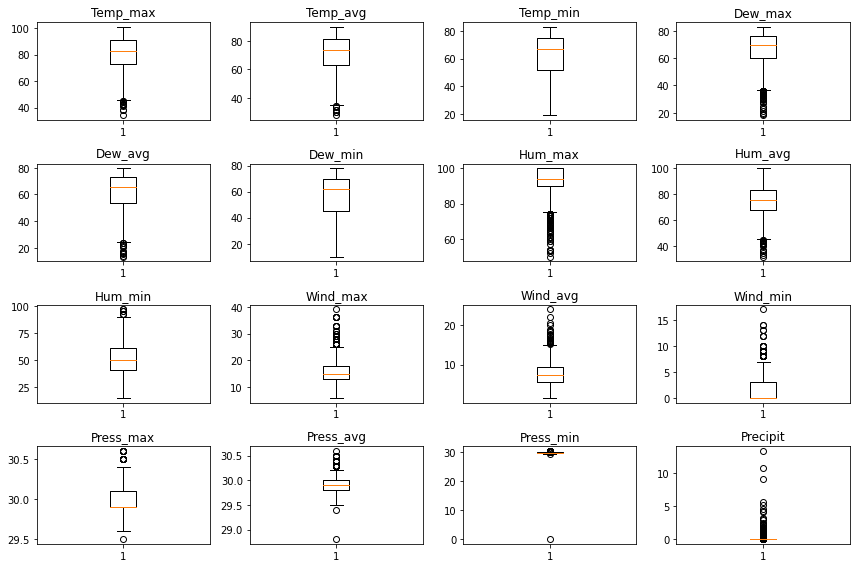

In [339]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(12,8))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    axs[j, i].boxplot(x=df_cons_pred[features_cont[count]])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

In [340]:
for feature in features_cont:
  filtro_upper = df_cons_pred[feature]> (df_cons_pred[feature].mean() + 3*df_cons_pred[feature].std())
  filtro_lower = df_cons_pred[feature]< (df_cons_pred[feature].mean() - 3*df_cons_pred[feature].std())
  index_drop = df_cons_pred.loc[filtro_upper | filtro_lower].index
  df_cons_pred.drop(index= index_drop, inplace=True)

In [341]:
df_cons_pred.shape

(1388, 20)

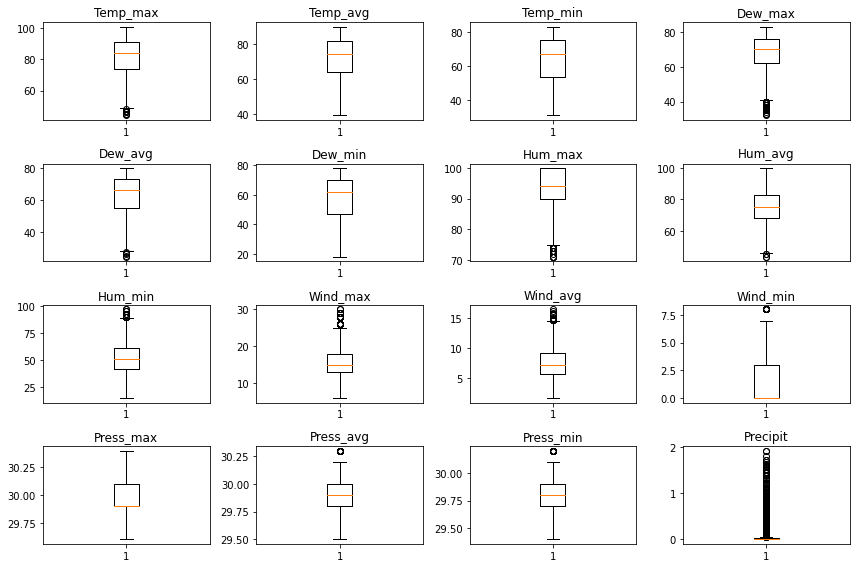

In [342]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(12,8))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    axs[j, i].boxplot(x=df_cons_pred[features_cont[count]])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

In [343]:
df_cons_pred.describe()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week,consumption
count,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000,1388.000000
mean,15.645533,81.710375,72.124856,63.613833,67.257205,62.836455,57.580692,93.425072,75.120965,51.692363,15.541787,7.503026,1.198847,29.967435,29.898271,29.827450,0.103919,2.998559,21.773926
std,8.785089,11.919266,11.685209,12.846019,10.965147,12.252014,13.986861,6.160390,10.759577,15.117651,4.474278,2.704762,2.187518,0.150625,0.144487,0.145552,0.286933,1.996030,12.844332
min,1.000000,44.000000,39.000000,31.000000,32.000000,24.700000,18.000000,71.000000,43.600000,15.000000,6.000000,1.600000,0.000000,29.600000,29.500000,29.400000,0.000000,0.000000,4.610000
25%,8.000000,74.000000,63.975000,53.750000,62.000000,55.075000,47.000000,90.000000,68.100000,42.000000,13.000000,5.600000,0.000000,29.900000,29.800000,29.700000,0.000000,1.000000,10.790750
50%,16.000000,84.000000,74.300000,67.000000,70.000000,66.400000,62.000000,94.000000,75.200000,51.000000,15.000000,7.200000,0.000000,29.900000,29.900000,29.800000,0.000000,3.000000,17.081000
75%,23.000000,91.000000,81.900000,75.000000,76.000000,73.225000,70.000000,100.000000,82.800000,61.000000,18.000000,9.200000,3.000000,30.100000,30.000000,29.900000,0.020000,5.000000,31.480500
max,31.000000,101.000000,90.000000,83.000000,83.000000,79.800000,78.000000,100.000000,99.900000,97.000000,30.000000,16.400000,8.000000,30.400000,30.300000,30.200000,1.920000,6.000000,78.225300


###Analise correlação

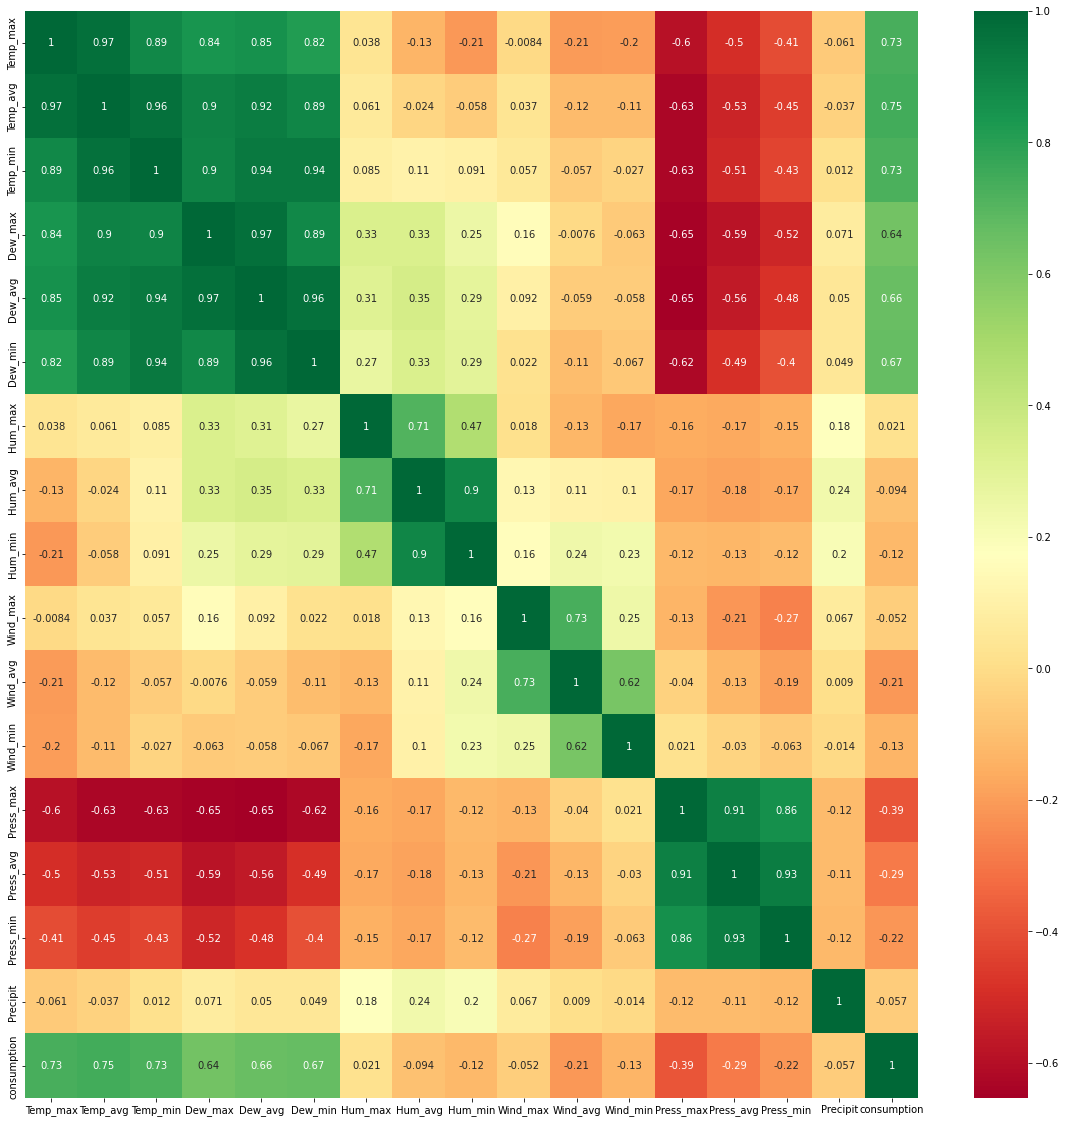

In [344]:
#correlacao linear
#get correlations of each features in dataset
corrmat = df_cons_pred[features_cont + ['consumption']].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_cons_pred[top_corr_features].corr(),annot=True,cmap="RdYlGn")

###Analise de escala

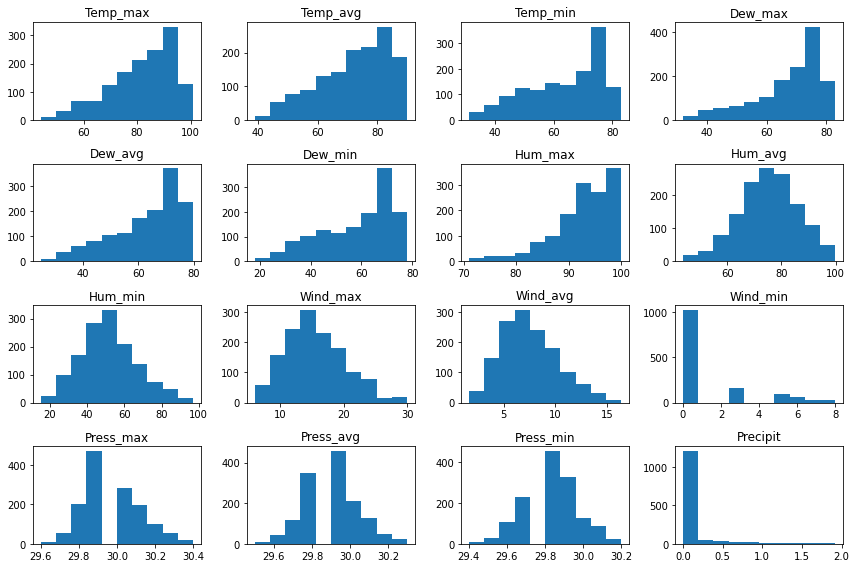

In [345]:
#Plot do histograma de cada coluna
n, m = 4, 4
fig, axs = plt.subplots(n, m,figsize=(12,8))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    axs[j, i].hist(x=df_cons_pred[features_cont[count]])
    axs[j, i].set_title(features_cont[count])
    plt.tight_layout()
    count +=1

####Mudança de Escala

In [346]:
scaler = StandardScaler()

In [347]:
for feature in features_cont:
  temp = StandardScaler().fit_transform(df_cons_pred[feature].values.reshape(-1, 1))
  df_cons_pred[feature] = temp

####Escala logarítmica

In [348]:
feature_log = ['Wind_min', 'Precipit']

In [349]:
for feature in feature_log:
  df_cons_pred[feature + '_log'] = np.log10(df_cons_pred[feature] + 1)

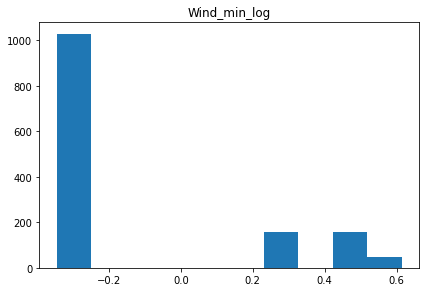

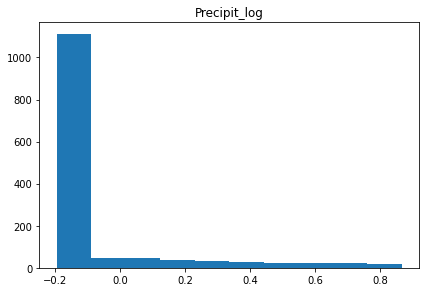

In [350]:
for feature in feature_log:
  fig, ax = plt.subplots()
  fig.tight_layout()
  ax.hist(x=df_cons_pred[feature + '_log'])
  ax.set_title(feature + '_log')

In [351]:
df_cons_pred.describe()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,...,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,day_of_week,consumption,Wind_min_log,Precipit_log
count,1388.000000,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,...,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1.388000e+03,1388.000000,1388.000000,1388.000000,1388.000000
mean,15.645533,-3.560232e-16,-4.586469e-16,1.372901e-15,6.408578e-16,1.024637e-16,-6.495465e-17,1.673653e-15,1.024477e-15,2.431612e-17,...,2.786728e-17,7.918738e-17,1.934124e-14,-8.241886e-15,7.701172e-15,1.031836e-17,2.998559,21.773926,-0.154052,-0.091705
std,8.785089,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,...,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.000360e+00,1.996030,12.844332,0.329019,0.228858
min,1.000000,-3.164957e+00,-2.835790e+00,-2.539743e+00,-3.216547e+00,-3.113790e+00,-2.830868e+00,-3.641515e+00,-2.930629e+00,-2.427996e+00,...,-2.183243e+00,-5.482376e-01,-2.440284e+00,-2.757434e+00,-2.937804e+00,-3.623039e-01,0.000000,4.610000,-0.345090,-0.195386
25%,8.000000,-6.471165e-01,-6.977019e-01,-7.681281e-01,-4.796196e-01,-6.337124e-01,-7.567463e-01,-5.561834e-01,-6.527669e-01,-6.413600e-01,...,-7.038371e-01,-5.482376e-01,-4.478639e-01,-6.803799e-01,-8.759441e-01,-3.623039e-01,1.000000,10.790750,-0.345090,-0.195386
50%,16.000000,1.921637e-01,1.862122e-01,2.636916e-01,2.502277e-01,2.909586e-01,3.160753e-01,9.336019e-02,7.348158e-03,-4.581483e-02,...,-1.120746e-01,-5.482376e-01,-4.478639e-01,1.197149e-02,-1.886573e-01,-3.623039e-01,3.000000,17.081000,-0.345090,-0.195386
75%,23.000000,7.796599e-01,8.368414e-01,8.866771e-01,7.976133e-01,8.482107e-01,8.882468e-01,1.067676e+00,7.139502e-01,6.159020e-01,...,6.276285e-01,8.236743e-01,8.804162e-01,7.043229e-01,4.986296e-01,-2.925760e-01,5.000000,31.480500,0.260947,-0.150320
max,31.000000,1.618940e+00,1.530275e+00,1.509663e+00,1.436230e+00,1.385051e+00,1.460418e+00,1.067676e+00,2.303805e+00,2.998083e+00,...,3.290560e+00,3.110194e+00,2.872836e+00,2.781377e+00,2.560490e+00,6.331577e+00,6.000000,78.225300,0.613862,0.865197


###Teste Anova

In [352]:
# Avaliação das features aplicando o teste Anova
test = SelectKBest(score_func=f_regression)
fit = test.fit(df_cons_pred[features_cont], df_cons_pred['consumption'])

#print das features e seus respectivos p-value
columns_cont_select = []
for value in zip(df_cons_pred[features_cont], fit.pvalues_):
  if value[1]<0.05:
    columns_cont_select.append(value[0])
    print(value)

('Temp_max', 1.2027131467913788e-235)
('Temp_avg', 7.619430073064956e-248)
('Temp_min', 9.616856075105704e-228)
('Dew_max', 1.6771744319184144e-158)
('Dew_avg', 3.376469221816593e-176)
('Dew_min', 4.8555900425885845e-178)
('Hum_avg', 0.00043845590805977904)
('Hum_min', 4.343432205700932e-06)
('Wind_avg', 1.2068195181125488e-15)
('Wind_min', 7.447844889158468e-07)
('Press_max', 5.567877637037409e-51)
('Press_avg', 1.6564690947380916e-27)
('Press_min', 2.743220666651347e-16)
('Precipit', 0.03465499332220789)


In [353]:
columns_cont_select

['Temp_max',
 'Temp_avg',
 'Temp_min',
 'Dew_max',
 'Dew_avg',
 'Dew_min',
 'Hum_avg',
 'Hum_min',
 'Wind_avg',
 'Wind_min',
 'Press_max',
 'Press_avg',
 'Press_min',
 'Precipit']

##Variáveis categóricas

In [354]:
columns_select = columns_cont_select + ['Date', 'consumption']

In [355]:
df_cons_pred = df_cons_pred[columns_select]

In [356]:
df_cons_pred['day'] = df_cons_pred.Date.dt.day.astype(str)
df_cons_pred['day_of_week'] = df_cons_pred.Date.dt.day_name()
df_cons_pred['month'] = df_cons_pred.Date.dt.month_name()
df_cons_pred['year'] = df_cons_pred.Date.dt.year.astype(str)

In [289]:
df_cons_pred.drop(columns=['Date'], inplace=True)

In [357]:
df_cons_pred.head()

,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_avg,Hum_min,Wind_avg,Wind_min,Press_max,Press_avg,Press_min,Precipit,Date,consumption,day,day_of_week,month,year
0,0.276092,0.229017,0.341565,0.615151,0.699202,0.602161,1.327578,0.880589,0.738584,-0.548238,-1.112004,-0.680380,-0.875944,-0.362304,2016-01-06,29.691,6,Wednesday,January,2016
1,1.031444,1.093669,0.964550,0.797613,0.911488,1.031290,-0.327358,-0.045815,-0.666852,-0.548238,-0.447864,0.011971,-0.188657,-0.362304,2016-01-07,43.177,7,Thursday,January,2016
2,1.283228,1.230643,0.886677,0.797613,0.854334,0.673683,-0.727146,-0.972218,-0.555896,-0.548238,0.216276,0.011971,0.498630,-0.362304,2016-01-08,50.057,8,Friday,January,2016
3,1.199300,1.204961,1.120297,0.706382,0.854334,0.888247,-0.745741,-0.376673,-0.444941,-0.548238,-1.112004,-0.680380,-0.875944,-0.327440,2016-01-09,47.363,9,Saturday,January,2016
4,-0.059620,-0.087737,-0.203547,-0.297158,-0.280582,-0.041532,-0.596983,-0.442845,-1.554496,-0.548238,0.216276,0.011971,0.498630,-0.362304,2016-01-10,42.203,10,Sunday,January,2016


In [358]:
features_cat = ['day', 'day_of_week', 'month', 'year']

###Analise de frequencia

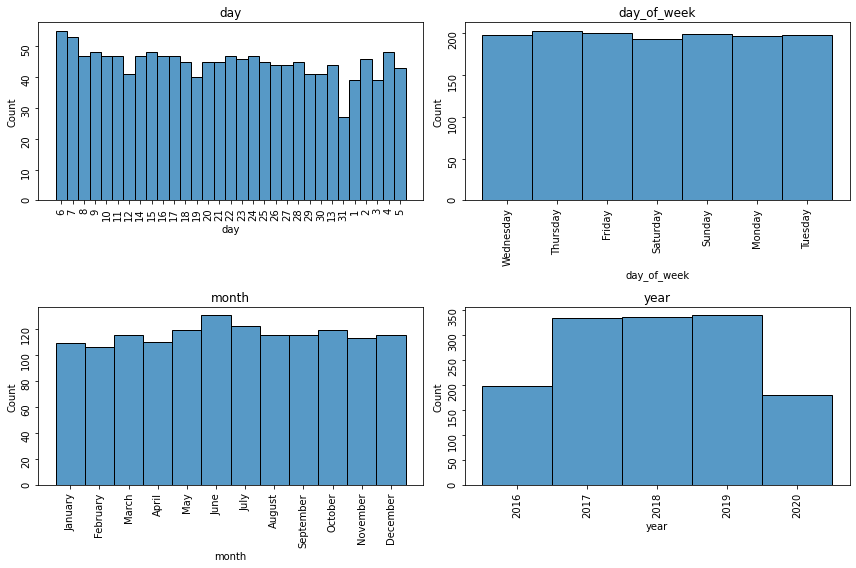

In [386]:
#Plot do histograma de cada coluna
n, m = 2, 2
fig, axs = plt.subplots(n, m,figsize=(12,8))
fig.tight_layout()
count = 0
for j in range(n):
  for i in range(m):
    ax = sns.histplot(x=df_cons_pred[features_cat[count]], ax=axs[j, i])
    axs[j, i].set_title(features_cat[count])
    ax.tick_params(labelrotation=90)
    plt.tight_layout()
    count +=1
#plt.xticks(rotation=45)
#locs, labels = plt.xticks()
#plt.setp(labels, rotation=45)

###One hot encoder + dummies

In [293]:
# Definindo a função Dummies
def dummies(x,df):
    
    #cria um dataframe temporario com o resultado do processo One-hot Encode e deletando a primeira coluna
    temp = pd.get_dummies(df[x], drop_first = True)
    
    #concatena o dataframe df com o temporario
    df = pd.concat([df, temp], axis = 1)
    
    #exclui a coluna referente ao atributo x
    df = df.drop(columns = x)
    
    return df

In [294]:
var_categ = ['day',	'day_of_week',	'month',	'year']

In [295]:
#aplica a função dummies para os atributos categoricos
for var in var_categ:
    df_cons_pred = dummies(var,df_cons_pred)

In [296]:
df_cons_pred.head()

,Day,Temp_max,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,...,June,March,May,November,October,September,2017,2018,2019,2020
0,1,85,74.8,68,74,71.4,66,100,89.4,65,...,0,0,0,0,0,0,0,0,0,0
1,1,94,84.9,76,76,74.0,72,94,71.6,51,...,0,0,0,0,0,0,0,0,0,0
2,1,97,86.5,75,76,73.3,67,96,67.3,37,...,0,0,0,0,0,0,0,0,0,0
3,1,96,86.2,78,75,73.3,70,88,67.1,46,...,0,0,0,0,0,0,0,0,0,0
4,1,81,71.1,61,64,59.4,57,90,68.7,45,...,0,0,0,0,0,0,0,0,0,0


#Treinamento e Teste

##Preparação

In [301]:
X = df_cons_pred.drop(columns=['consumption'])
y = df_cons_pred.consumption

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

##Modelos

###Regressão Linear

In [57]:
LM = LinearRegression()

In [58]:
LM.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


LinearRegression()

In [59]:
r2_score(y_test, LM.predict(X_test))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


0.6851955318922007

###Random Forest Regressor

####Tuning hiperparametros

In [176]:
# Conjunto de valores para os Hiperparametros
params = {
    "n_estimators": (1, 5000),
    "max_depth": (1, 500),
    "max_features": ['auto', 'sqrt', 'log2'],
    "criterion": ['squared_error', 'absolute_error', 'poisson'],
}

In [1]:
p = X_train.shape[1]
params = {
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
    'n_estimators': Integer(50, 1000),
    'max_features': Real(1/p, 1, prior='uniform'),
    'max_depth': Integer(1, 101),
    'min_samples_split': Integer(2, 11),
    'min_samples_leaf': Integer(1, 11),
}

NameError: ignored

In [196]:
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_RF = BayesSearchCV(estimator = RandomForestRegressor(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_RF.fit(X_test,y_test)

CPU times: user 38min 42s, sys: 13.4 s, total: 38min 55s
Wall time: 38min 52s


In [197]:
# Melhores valores para os paramentros:
print('n_estimators: {}'.format(BS_RF.best_params_['n_estimators']))
print('max_depth: {}'.format(BS_RF.best_params_['max_depth']))
print('criterion: {}'.format(BS_RF.best_params_['criterion']))
print('max_features: {}'.format(BS_RF.best_params_['max_features']))
print('Best Score: {}'.format(BS_RF.best_score_))

n_estimators: 5000
max_depth: 101
criterion: absolute_error
max_features: 1.0
Best Score: 0.7661248342540941


####Treinamento, validação e teste

In [95]:
RFR = RandomForestRegressor(n_estimators= 5000, max_depth=101, criterion='absolute_error')

In [96]:
RFR.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=101,
                      n_estimators=5000)

In [98]:
r2_score(y_test, RFR.predict(X_test))

0.761111802391276

###Regressão Linear com Regularização Lasso

In [ ]:
Lasso = LassoCV(cv=10)

In [ ]:
Lasso.fit(X_train, y_train)

In [ ]:
Lasso.score(X_test, y_test)

In [ ]:
Lasso.coef_

In [ ]:
#print das features e seus respectivos p-value
for value in [*zip(df_cons_pred.columns.values[:-1], Lasso.coef_)]:
  print(value)

In [ ]:
Ridge = RidgeCV()

In [ ]:
Ridge.fit(X_train, y_train)

In [ ]:
Ridge.score(X_test, y_test)

###Bayesian Regression

In [59]:
from sklearn.linear_model import BayesianRidge

In [60]:
BR = BayesianRidge()

In [61]:
BR.fit(X_train, y_train)

BayesianRidge()

In [65]:
BR.score(X_test, y_test)

0.6555917932488169

###Support Vector Machines Regression

In [70]:
from sklearn.svm import SVR

#####Tuning hiperparametros

In [86]:
# Conjunto de valores para os Hiperparametros
params = {
          'C': (1e-3, 1e+3, 'log-uniform'),
          #'gamma': (1e-2, 1e+1, 'log-uniform'),
          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
         }

In [87]:
%%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_SVC = BayesSearchCV(estimator = SVR(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_SVC.fit(X_test,y_test)

CPU times: user 1min 21s, sys: 5.75 s, total: 1min 27s
Wall time: 1min 20s


In [88]:
BS_SVC.best_params_

OrderedDict([('C', 23.13022772446096), ('kernel', 'rbf')])

In [89]:
BS_SVC.best_score_

0.6968999906940048

#####Treinamento, validação e teste

In [91]:
classif_fault_SVM = SVR(C = 23.1302 )

In [92]:
classif_fault_SVM.fit(X_train, y_train)

SVR(C=23.1302)

In [93]:
classif_fault_SVM.score(X_test, y_test)

0.7479552361884236

###XGBoost Classifier

In [99]:
from xgboost import XGBRegressor

#####Tuning hiperparametros

In [ ]:
# Conjunto de valores para os Hiperparametros
params = {
    "eta": (0,1),
    "gamma": (0, 200),
    "max_depth": (1, 100),
    'n_estimators':(1,5000),
}


In [ ]:
%time
# Criação da class BayesSearchCV para os parametros escolhidos e tendo o recall como metrica de avaliacao:
BS_XGB = BayesSearchCV(estimator = XGBRegressor(),
                       search_spaces = params,
                       scoring='r2',
                       cv = 10,
                       n_iter = 20, 
                       random_state=123)

# Realizando a otimização por BayesSearchCV para a deteccao de curto circuito:
BS_XGB.fit(X_test,y_test)


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


BayesSearchCV(cv=10, estimator=XGBClassifier(), n_iter=20, random_state=123,
              scoring='recall',
              search_spaces={'eta': (0, 1), 'gamma': (0, 200),
                             'max_depth': (1, 100), 'n_estimators': (1, 5000)})

In [ ]:

# Melhores valores para os paramentros:
print('eta: {}'.format(BS_XGB.best_params_['eta']))
print('gamma: {}'.format(BS_XGB.best_params_['gamma']))
print('max_depth: {}'.format(BS_XGB.best_params_['max_depth']))
print('n_estimators: {}'.format(BS_XGB.best_params_['n_estimators']))
print('Best Score: {}'.format(BS_XGB.best_score_))


eta: 1
gamma: 0
max_depth: 6
n_estimators: 2391
Best Score: 0.9948583082868183


#####Treinamento, validacao e teste

In [297]:
classif_fault_XGB = XGBRegressor()#(eta=1, gamma=0, max_depth=6, n_estimators=2391)

In [303]:
classif_fault_XGB.fit(X_train, y_train)

[14:14:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [305]:
classif_fault_XGB.score(X_test, y_test)

0.773495810370575

###LGBM Regressor

In [102]:
from lightgbm import LGBMRegressor

In [103]:
LGBM = LGBMRegressor()

In [104]:
LGBM.fit(X_train, y_train)

LGBMRegressor()

In [105]:
LGBM.score(X_test,y_test)

0.7494486449937683

###Stochastic Gradient Descent Regression

In [106]:
from sklearn.linear_model import SGDRegressor

In [107]:
SGDR = SGDRegressor()

In [108]:
SGDR.fit(X_train, y_train)

SGDRegressor()

In [109]:
SGDR.score(X_test,y_test)

0.6491956688278977